In [1]:
# run this when using colab environment
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/datasets/petfinder-pawpularity-score .

Mounted at /content/drive


In [2]:
# run this when you comeback to your personal environment

Approach this problem from 2 different angles. First use only clear images of pets and match it with the pawpularity score. Alternatively, use tabular data provided use it make a prediction of pawpularity score.
Use additional models to analyse text data and its meaning and its correlation to pawpularity. Consider a transformer network for this purpose.

In [25]:
import numpy as np
import torch
from PIL import Image
from torchvision import models
import pandas as pd
from torchvision import transforms
from scipy import stats
from matplotlib import pyplot as plt


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [24]:
# Local Environment
DATASET_PATH = '../../datasets/petfinder-pawpularity-score/'
MODELS_PATH = 'models/'

# Colab environment
# DATASET_PATH = '/content/drive/MyDrive/datasets/petfinder-pawpularity-score/'
# DATASET_PATH = '/content/petfinder-pawpularity-score/'
# MODELS_PATH = "/content/drive/MyDrive/projects/PetFinder/models/"

### Load Dataset

In [26]:
train = pd.read_csv(DATASET_PATH + 'train.csv')
train.head()


Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

filter collages and text

In [27]:
def read_image_paths(dataset_dir, data_df):
    images = data_df['Id'].to_list()
    labels = data_df['Pawpularity'].to_list()
    image_paths = [dataset_dir + "train/" + image + '.jpg' for image in images]
    return image_paths, labels

images_paths, labels = read_image_paths(DATASET_PATH, train)


In [28]:
def Generator():
    def __init__(self, X_preprocessing, y_preprocessing = None, device = torch.device('cpu')):
        self.X_preprocessing = X_preprocessing
        if y_preprocessing != None:
            self.y_preprocessing = y_preprocessing

        self.device = device
        
    
    def __call__(self, X, y, batch_size):
        batch_size = []

        X_val_batch = []
        y_val_batch = []
        batch_coutner = 0
        for X_val, y_val in zip(X,y):
            X_val_preproc = self.preprocessing(X_val)
            if self.y_preprocessing != None:
                y_val_preproc = self.y_preprocessing(y_val)
            else:
                y_val_preproc = y
            
            X_val_batch.append(X_val_preproc)
            y_val_batch.append(y_val_preproc)
            batch_coutner += 1
            if batch_counter == batch_size:
                X_val_batch = torch.stack(X_val_batch).type(torch.FloatTensor)
                y_val_batch = torch.tensor(y_val_batch).type(torch.FloatTensor).unsqueeze(1)
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)
                yield X_val_batch, y_val_batch
                X_val_batch = []
                y_val_batch = []
                batch_counter = 0


        
        

In [29]:
image_paths, labels = read_image_paths(DATASET_PATH, train)


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

preprocessing = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            normalize,
                            ])


X_preprocessing = preprocessing

# img_pils = [Image.open(im_path) for im_path in image_paths]


In [30]:
def read_image_generator(image_paths, labels, batch_size, device):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    preprocessing = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize,
                                ])
    batch_imgs = []
    batch_labels = []
    batch_counter = 0
    for img_path, label in zip(image_paths, labels):
        img = Image.open(img_path)
        img_preprocessed = preprocessing(img)
        batch_imgs.append(img_preprocessed)
        batch_labels.append(label)
        batch_counter += 1
        # print(batch_counter)
        if batch_counter == batch_size:
            batch_imgs = torch.stack(batch_imgs).type(torch.FloatTensor)
            batch_labels = torch.tensor(batch_labels).type(torch.FloatTensor).unsqueeze(1)
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            yield batch_imgs, batch_labels
            batch_imgs = []
            batch_labels = []
            batch_counter = 0



    

Test the image generator

In [ ]:
# images_paths, labels = read_image_paths(DATASET_PATH, train)
# N = 300
# images_paths = images_paths[:N]
# labels = labels[:N]

# total = 0
# correct = 0
# batch_size = 32
# # with torch.no_grad():
# with torch.no_grad():
#     for img_arr, label in read_image_generator(images_paths, labels, batch_size=batch_size, device='cpu'):
#         print(img_arr.shape, label.shape)
#         print(img_arr.dtype, label.dtype)

#         print(resnet50(img_arr).shape)

#         break

#         total += batch_size



### Dataset Analysis and Overview

General analytics of the images. Which images pootentially can look good and which ones does not.
Does additional information or collages have a higher pawpularity score?
Does text make your pet look better?
Can we analyse the text on the image and whether the meaning of the text has correlation with pawpularity score?

Dataset contans collages and text. It worth checking what the meaning of the text and detect collages. Can we split collages into multiple images?

#### Target Variable Transformation and Standartisation

Visualise original Pawpularity

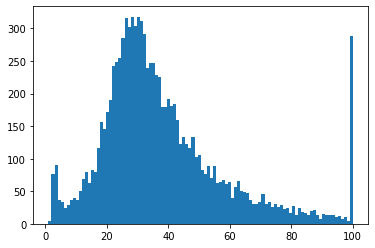

In [31]:
hist = plt.hist(train['Pawpularity'].to_numpy(), bins=100)

Normalise the data

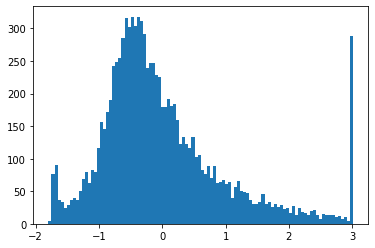

In [ ]:
mean = train['Pawpularity'].mean()
std = train['Pawpularity'].std()

pawpularity_norm = (train['Pawpularity'] - mean) / std

hist = plt.hist(pawpularity_norm.to_numpy(), bins=100)


Make target variable closer to normal distribution

In [ ]:
_, p = stats.normaltest(pawpularity_norm)
print(p)
# p is 0.0, which means the data is not normally distributed.

0.0


Try different transformation to get it closer to normal distribution

Square root transformation

8.248036511340364e-43


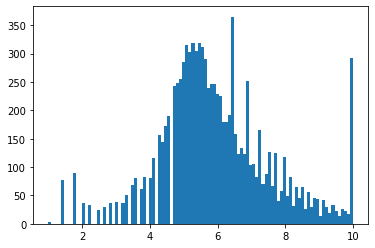

In [ ]:
pawpularity_sqrt = np.sqrt(train['Pawpularity'].to_numpy())

hist = plt.hist(pawpularity_sqrt, bins = 100)
_, p = stats.normaltest(pawpularity_sqrt)
print(p) # p is 8.248036511340364e-43 , which means the data is not normally distributed.


Logarihtmic transformation

0.0


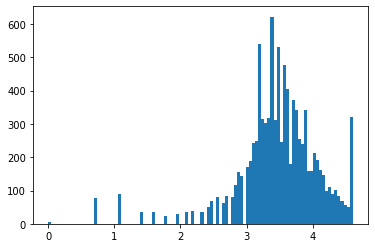

In [ ]:
pawpularity_log = np.log(train['Pawpularity'].to_numpy())

hist = plt.hist(pawpularity_log, bins = 100)
_, p = stats.normaltest(pawpularity_log)
print(p) # p is 8.248036511340364e-43 , which means the data is not normally distributed.

Box Cox Transformation

3.5113437246263224e-30


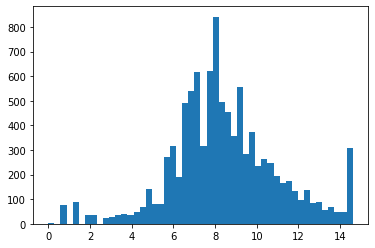

In [ ]:
pawpularity_bc, lambda_bc = stats.boxcox(train['Pawpularity'].to_numpy())

hist = plt.hist(pawpularity_bc, bins = 50)
_, p = stats.normaltest(pawpularity_bc)
print(p)

Create weights for each class from 1 to 100. There are in total 100 classes. The most popular class has weight of 1. Other classes are computed as max_count/class_count giving higher weights to classes that are less popular.

In [ ]:
# verify that all classes exist
unique_classes = train['Pawpularity'].unique()
len(unique_classes)
print(np.min(unique_classes), np.max(unique_classes))


1 100


In [ ]:
max_count = train['Pawpularity'].value_counts().max()
weights = np.empty((100), dtype=np.float32)

for index, value in train['Pawpularity'].value_counts().iteritems():
    # print(index, value)
    weights[index-1] = max_count / value # -1 because index starts from 1
    # break

print(weights)

#### Analysis of the collages and text

#### Visualise Different Attrbs Image

In [ ]:
train.columns

Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur',
       'Pawpularity'],
      dtype='object')

607


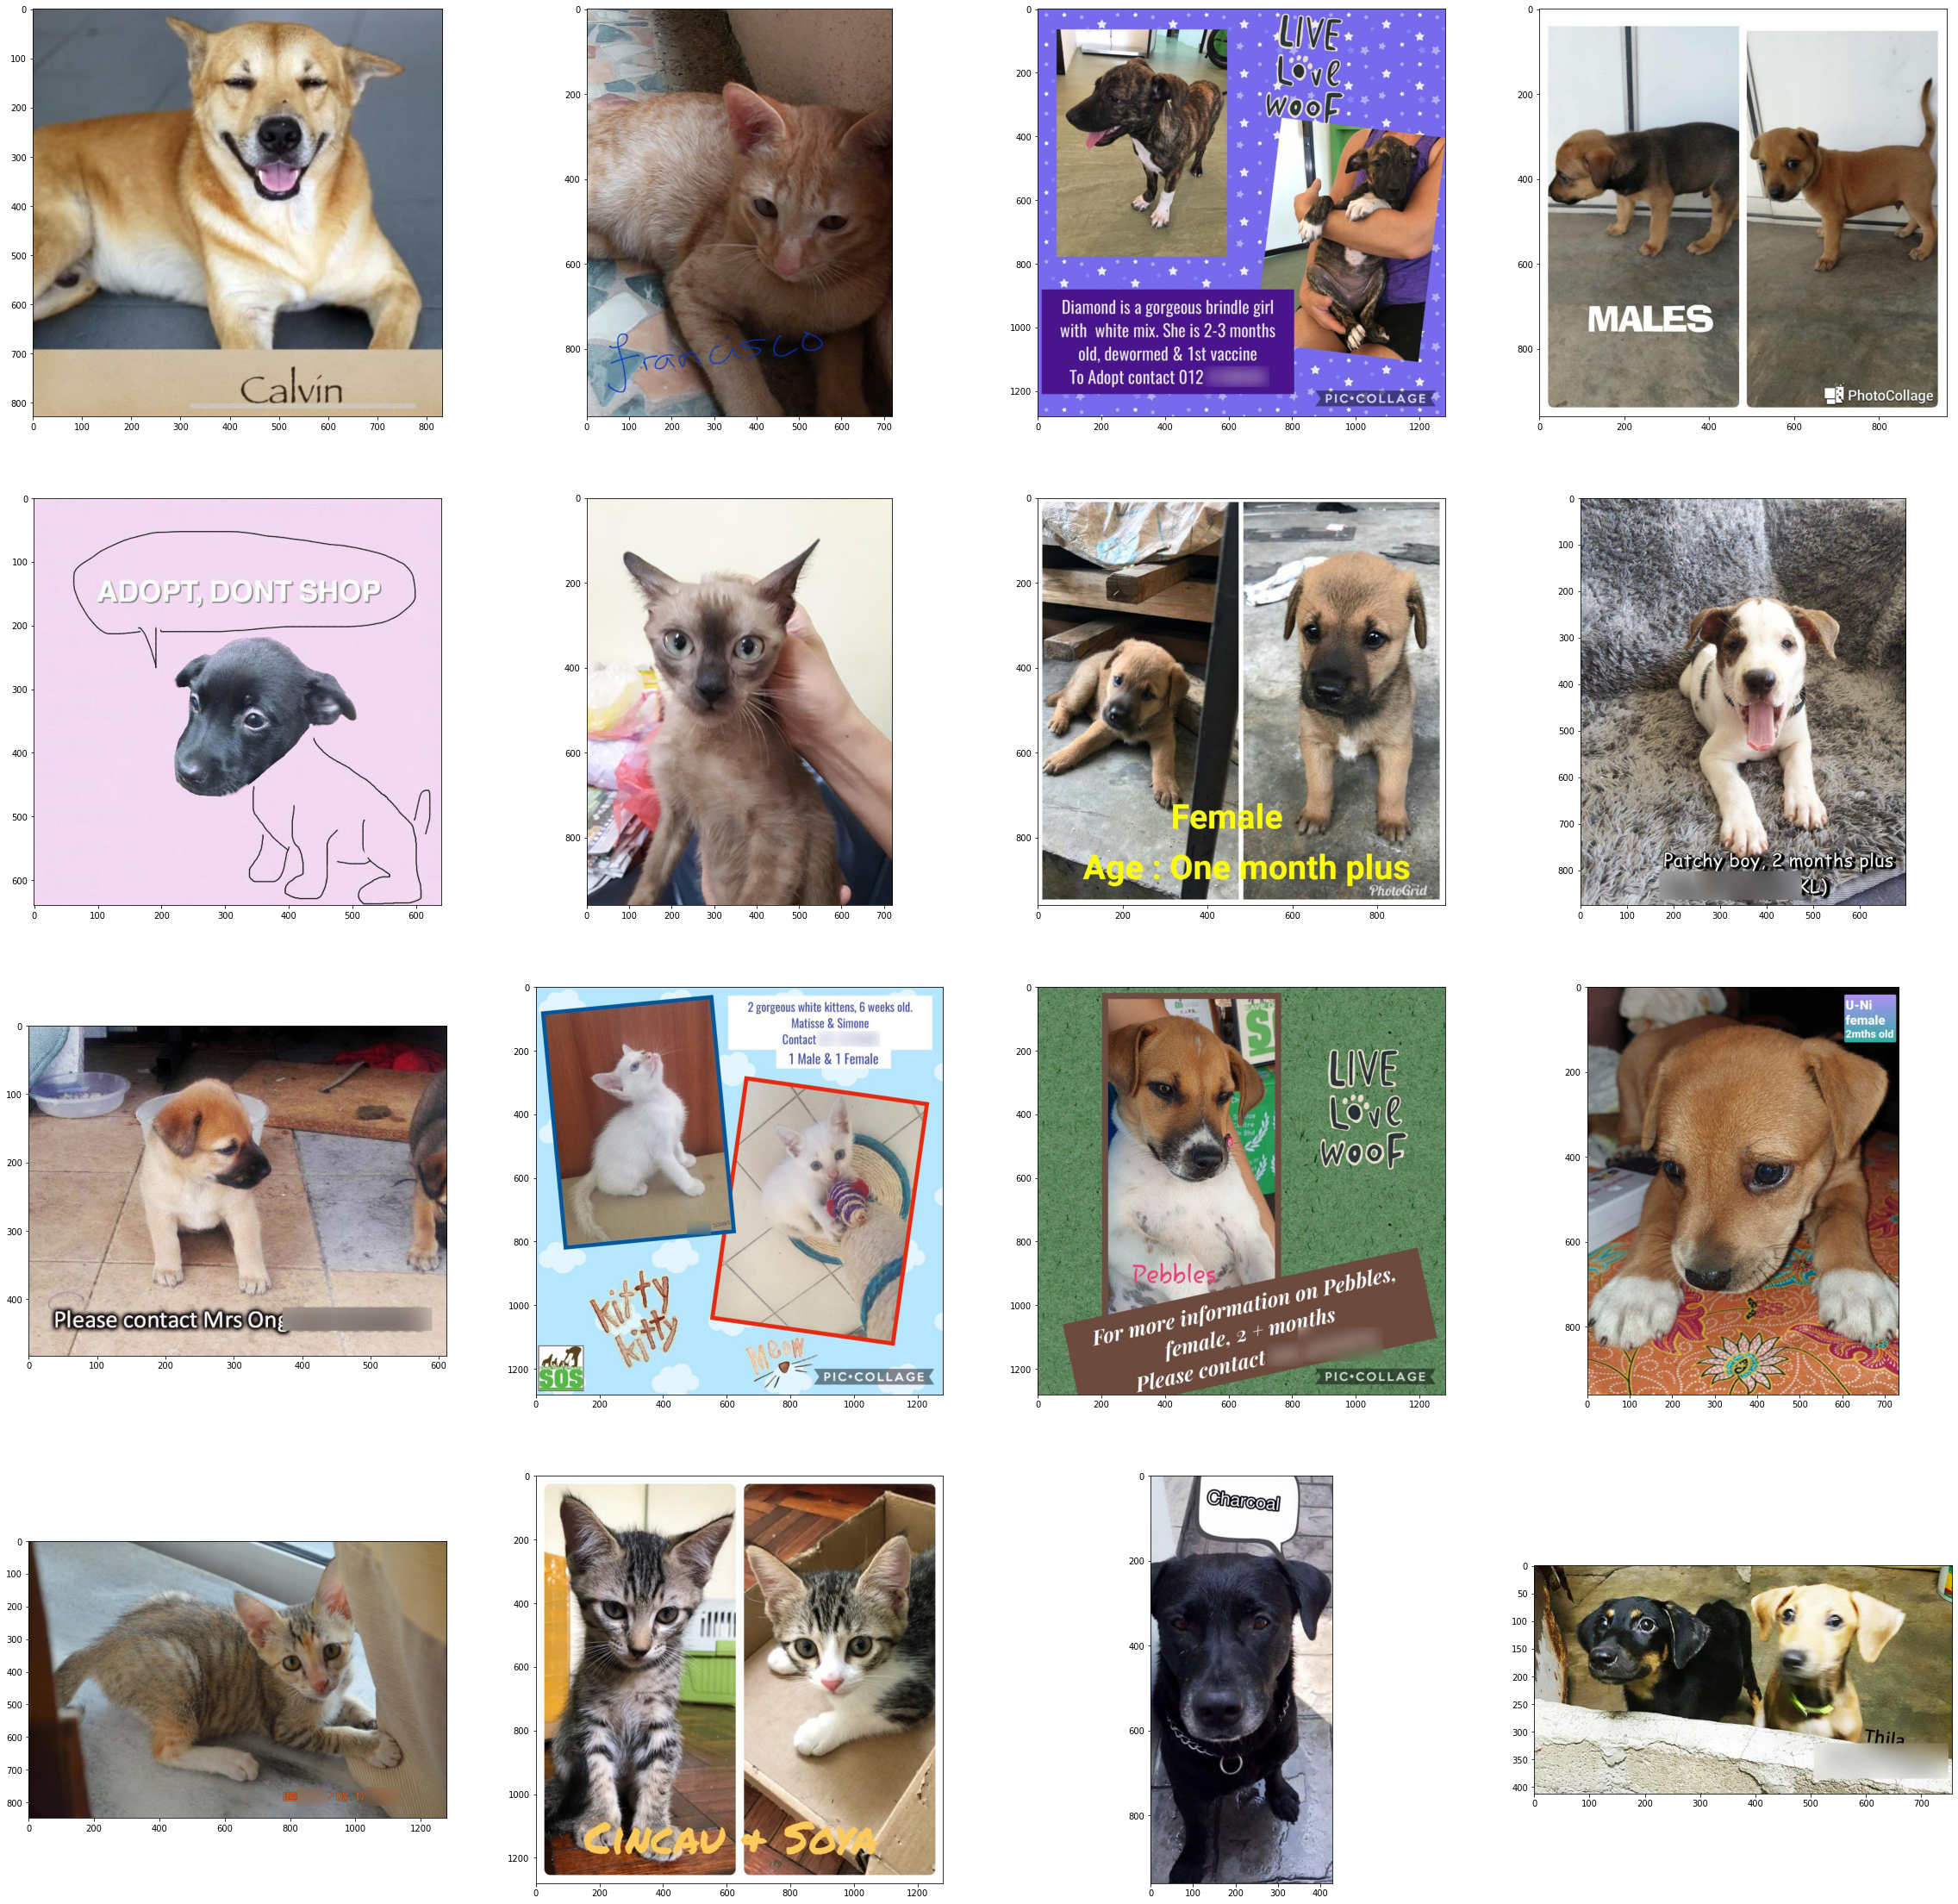

In [ ]:
attr = 'Info'
attr_idx = train[attr].where(train[attr] ==1).dropna().index.to_numpy()
print(len(attr_idx))
N = 16
fig,axs = plt.subplots(4,N//4, figsize=(40,40))
# pick random images from the accessory class
for i, idx in enumerate(np.random.choice(attr_idx, size=N)):
    IMG_PATH = DATASET_PATH + 'train/' + train['Id'].iloc[idx] + '.jpg'
    # print(IMG_PATH)

    img = Image.open(IMG_PATH)
    axs[i//(N//4),i%(N//4)].imshow(img)



Is there a way to automatically split collages?? Probably the approach is to do this manually??

#### Use object detection to extract pets from the collages

Use pretrained object detection model to extact objecs from the collages.

In [ ]:
frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
# try to run detection on one of the collage images and see how well it can perform


#### Use OCR to extract text from the collages and info images

### Test torch accuracy using ImageNet. Need to download the dataset
You need to download ImageNet validation dataset.

### Use ImageNet pretrained model and fine tune them on the dataset
Do this only for clear images without any text or collages.

Exclude collages and info images from the dataset for now

['../../datasets/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg', '../../datasets/petfinder-pawpularity-score/train/0009c66b9439883ba2750fb825e1d7db.jpg', '../../datasets/petfinder-pawpularity-score/train/0013fd999caf9a3efe1352ca1b0d937e.jpg', '../../datasets/petfinder-pawpularity-score/train/0018df346ac9c1d8413cfcc888ca8246.jpg', '../../datasets/petfinder-pawpularity-score/train/001dc955e10590d3ca4673f034feeef2.jpg']


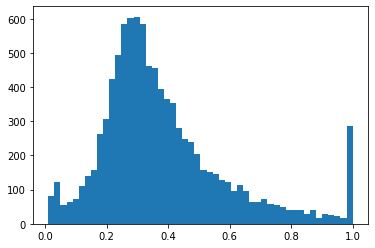

In [32]:
train_filtered = train.where((train['Collage'] ==0) | (train['Info'] == 0)).dropna()
train_filtered_X = train_filtered['Id'].to_numpy()
train_filtered_X = [DATASET_PATH + 'train/' + image + '.jpg' for image in train_filtered_X]
# train_filtered_X = [Image.open(img_path) for im_path in train_filtered_X] # load your data to PILLOW format
train_filtered_y = train_filtered['Pawpularity'].to_numpy()
train_filtered_y_norm = train_filtered_y/100
# train_filtered_y, lambda_bc = stats.boxcox(train_filtered_y)
# train_filtered_y_mean = train_filtered_y.mean()
# train_filtered_y_std = train_filtered_y.std()
# trian_filtered_y_norm = (train_filtered_y - train_filtered_y_mean) / train_filtered_y_std
print(train_filtered_X[0:5])

hist = plt.hist(train_filtered_y_norm, bins=50)
# print(len(train_filtered))


# # visualise differet random pices of data
# print(train_filtered.sample(1)['Id'].values[0])
# IMG_PATH = DATASET_PATH + 'train/' + train_filtered.sample(1)['Id'].values[0] + '.jpg'
# img = Image.open(IMG_PATH)
# img


Split Train into train and validation using sklearn train_test_split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_filtered_X, train_filtered_y_norm, test_size=0.10, random_state=42)


Fine-tune model on the dataset

In [36]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
resnet50.fc = torch.nn.Linear(2048, 1) # replace the last layer with a 100 class output layer
resnet50 = resnet50.to(device)

optimiser = torch.optim.Adam(resnet50.parameters(), lr=0.0001) # optimise with low learning rate
loss_fn = torch.nn.MSELoss()

PATH = MODELS_PATH + "resnet50.pt"

In [37]:
checkpoint = torch.load(PATH)
resnet50.load_state_dict(checkpoint['model_state_dict'])
optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [ ]:
# images_paths, labels = read_image_paths(DATASET_PATH, X_train)
batch_size = 64
# N = batch_size * 10
# images_paths = images_paths[:N]
# labels = labels[:N]

total = 0
correct = 0
# with torch.no_grad():
# loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights))

losses = []

epochs = 10



for epoch in range(epochs):
    print("Epoch: ", epoch)
    for img_arr, label in read_image_generator(X_train[0:1500], y_train, batch_size=batch_size, device = device):
        out = resnet50(img_arr)
        # out = out.argmax(dim=1) + 1 # add 1 to make it start from 1 instead of 0
        # print(label.dtype)
        # out = torch.clip(out, 1, 100)
        loss = loss_fn(out, label)
        # weights_scale = weights[label.detach().numpy().astype(np.int16)-1]
        # loss = loss * torch.Tensor(weights_scale) # scale the loss
        # loss = loss.sum()
        # print(loss.dtype)
        loss.backward()

        optimiser.step()

        optimiser.zero_grad()
    

    torch.save({
            'epoch': epoch,
            'model_state_dict': resnet50.state_dict(),
            'optimizer_state_dict': optimiser.state_dict(),
            'loss': loss,
            }, PATH)

    losses.append(loss.item())



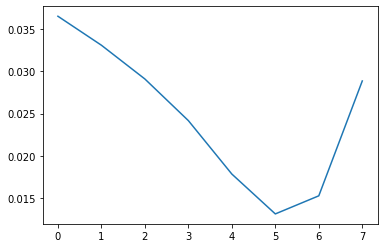

In [43]:
plt.plot(losses)

#### Run tests on the model

In [44]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocessing = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            normalize,
                            ])

In [47]:
umi_img = Image.open("884e5c17-98de-482d-9c14-d83afa441d41_Original.jpg")
# umi_img = Image.open("4abd0d9c-81e4-45ab-9776-c8e168f68dbd_Original.jpg")

umi_img = preprocessing(umi_img).unsqueeze(0)
with torch.no_grad():
    out = resnet50(umi_img)
    print(out*100)
    print(out.shape)
    print(out.dtype)

tensor([[56.3434]])
torch.Size([1, 1])
torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


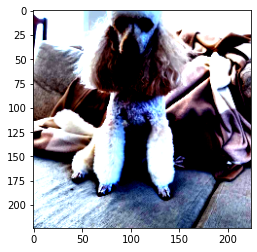

In [53]:
plt.imshow(umi_img.squeeze(0).permute(1,2,0))

### create a simple FC model for tabular data and train it to match pawpularity
Is there a patter between the collages and the text?


In [ ]:
train_tabular = train.drop(columns=['Id'])


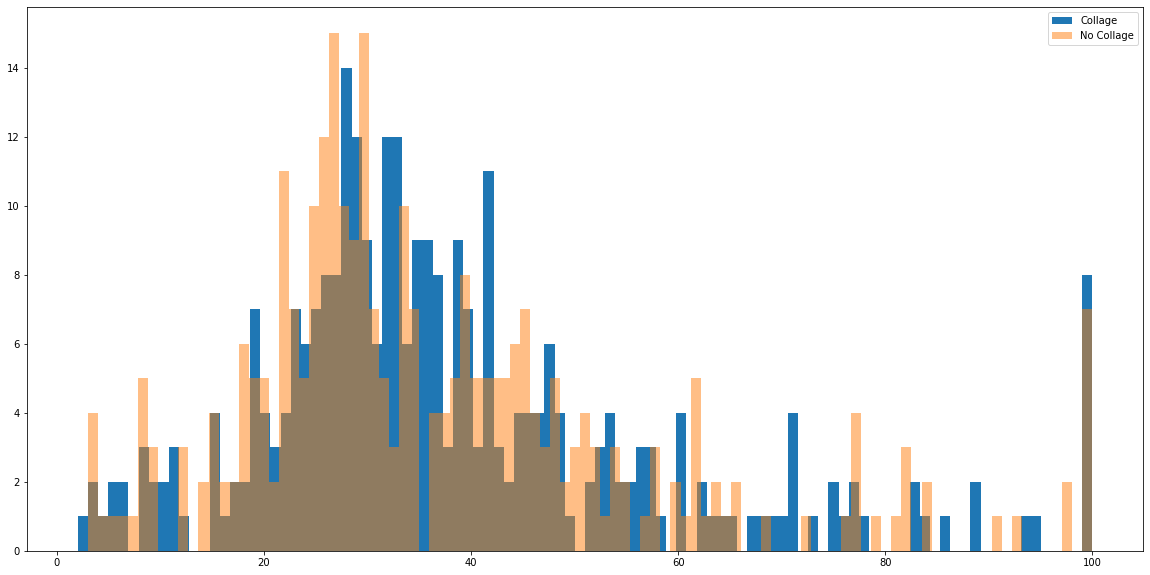

In [ ]:
N = 300
train_tabular_collages = train_tabular[train_tabular['Collage'] == 1].sample(n = N)
train_tabular_no_collages = train_tabular[train_tabular['Collage'] == 0].sample(n = N)


figure = plt.figure(figsize=(20,10))
hist = plt.hist(train_tabular_collages['Pawpularity'].to_numpy(), bins = 100, alpha = 1)
hist = plt.hist(train_tabular_no_collages['Pawpularity'].to_numpy(), bins = 100, alpha = 0.5)
plt.legend(['Collage', 'No Collage'])

# plt.scatter(train_tabular_collages.index, train_tabular_collages['Pawpularity'])
# plt.scatter(train_tabular_no_collages.index, train_tabular_no_collages['Pawpularity'])